# ANA 699 Capstone Project  
## Motorcycle Crash Risk and Injury Severity Analysis

**Team Members:**  
Amber Garcia  
Ed Baek  
Jeremiah Snipes  
Ryan Neighbor  

**Course:** ANA 699A – Analytic Capstone Project I  
**Institution:** National University  

## Project Overview
This notebook supports the ANA 699 capstone project focused on analyzing motorcycle crash data from Southern California. The objective is to explore injury severity patterns, contributing factors, and spatial risk using event-level crash records derived from official California traffic collision data.

At this stage of the capstone, the notebook emphasizes data understanding, exploratory analysis, and methodological planning. Modeling approaches may evolve as the project progresses.


# Boilerplate Packages

In [8]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Deep Learning
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Evaluation & Visualization
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Settings
plt.style.use("ggplot")
sns.set_theme(style="whitegrid")
np.random.seed(42)
tf.random.set_seed(42)

# Load and Explore the Data

In [13]:
file_path = r"C:\Users\divin\Documents\ANA_699A\motorcycle_risk_project\data\SoCal_Motorcycle_Crashes.csv"

df = pd.read_csv(file_path, low_memory=False)

df.head()


,CASE_ID,ACCIDENT_YEAR,PROC_DATE,JURIS,COLLISION_DATE,COLLISION_TIME,OFFICER_ID,REPORTING_DISTRICT,DAY_OF_WEEK,CHP_SHIFT,...,COUNT_MC_KILLED,COUNT_MC_INJURED,PRIMARY_RAMP,SECONDARY_RAMP,LATITUDE,LONGITUDE,COUNTY,CITY,POINT_X,POINT_Y
0,81386057,2021,2021-01-12,1942,2021-01-09,1455,30947,0719,6,5,...,0,1,-,-,NaN,NaN,LOS ANGELES,LOS ANGELES,-118.324829,34.076233
1,81386600,2021,2021-01-13,1942,2021-01-11,1440,34959,0813,1,5,...,1,0,-,-,NaN,NaN,LOS ANGELES,LOS ANGELES,-118.468544,34.071571
2,81386739,2021,2021-01-13,1942,2021-01-10,1153,34959,0898,7,5,...,0,1,-,-,NaN,NaN,LOS ANGELES,LOS ANGELES,-118.388931,34.036381
3,81395130,2021,2021-01-27,1942,2021-01-26,1400,38013,NaN,2,5,...,0,1,-,-,NaN,NaN,LOS ANGELES,LOS ANGELES,-118.344032,34.068905
4,81400706,2021,2021-02-02,1942,2021-01-19,1330,37511,2055,2,5,...,0,1,-,-,NaN,NaN,LOS ANGELES,LOS ANGELES,-118.299980,34.049068


### Basic Information

This section provides a high-level overview of the dataset structure, including the number of observations, variables, data types, and the presence of missing values. This step is intended to confirm data integrity and inform later preprocessing decisions.


In [15]:
# Dataset shape
print("Dataset shape (rows, columns):")
df.shape


Dataset shape (rows, columns):


(17322, 80)

In [17]:
# Column names and data types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17322 entries, 0 to 17321
Data columns (total 80 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CASE_ID                  17322 non-null  int64  
 1   ACCIDENT_YEAR            17322 non-null  int64  
 2   PROC_DATE                17322 non-null  object 
 3   JURIS                    17322 non-null  int64  
 4   COLLISION_DATE           17322 non-null  object 
 5   COLLISION_TIME           17322 non-null  int64  
 6   OFFICER_ID               17320 non-null  object 
 7   REPORTING_DISTRICT       5537 non-null   object 
 8   DAY_OF_WEEK              17322 non-null  int64  
 9   CHP_SHIFT                17322 non-null  int64  
 10  POPULATION               17322 non-null  int64  
 11  CNTY_CITY_LOC            17322 non-null  int64  
 12  SPECIAL_COND             17322 non-null  int64  
 13  BEAT_TYPE                17322 non-null  int64  
 14  CHP_BEAT_TYPE         

In [19]:
# Summary of missing values
df.isna().sum().sort_values(ascending=False).head(15)


BICYCLE_ACCIDENT       17261
PEDESTRIAN_ACCIDENT    17188
TRUCK_ACCIDENT         17004
CALTRANS_DISTRICT      16868
RAMP_INTERSECTION      16868
ALCOHOL_INVOLVED       16057
CITY_DIVISION_LAPD     16017
ROUTE_SUFFIX           14672
POSTMILE_PREFIX        13868
CALTRANS_COUNTY        12602
POSTMILE               12602
LOCATION_TYPE          12429
REPORTING_DISTRICT     11785
SIDE_OF_HWY            11046
STATE_ROUTE            10713
dtype: int64

Many variables contain missing values because they are conditionally recorded fields. For example, pedestrian, bicycle, and truck indicators are only populated when those crash types are involved. Since this dataset focuses on motorcycle crashes, high levels of missingness in these fields are expected and do not indicate data quality issues. Handling of missing values will be addressed during preprocessing based on analytical needs.


### Visualize the Data

This section provides exploratory visualizations to understand the distribution of key variables related to motorcycle crash outcomes. The goal is to identify broad patterns in injury severity, alcohol involvement, and temporal factors prior to formal modeling.

#### Injury severity distribution

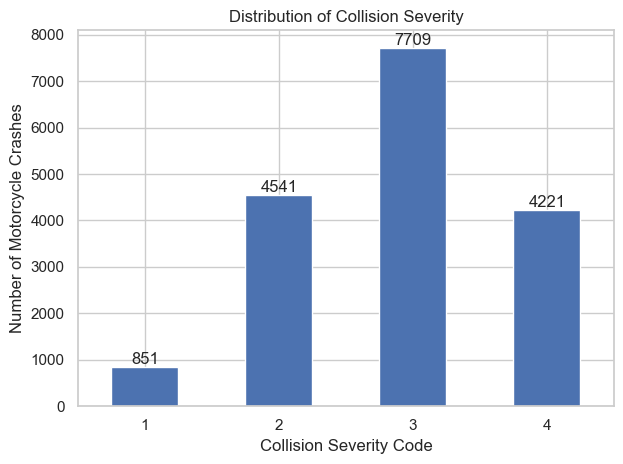

In [23]:
import matplotlib.pyplot as plt

severity_counts = df['COLLISION_SEVERITY'].value_counts().sort_index()

ax = severity_counts.plot(
    kind='bar',
    title='Distribution of Collision Severity',
    xlabel='Collision Severity Code',
    ylabel='Number of Motorcycle Crashes'
)

# x-axis tick labels: make them normal (0 degrees)
ax.tick_params(axis='x', labelrotation=0)

# Add value labels on top of bars
for i, value in enumerate(severity_counts):
    ax.text(i, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()


#### Research Questions Visual Support Aids

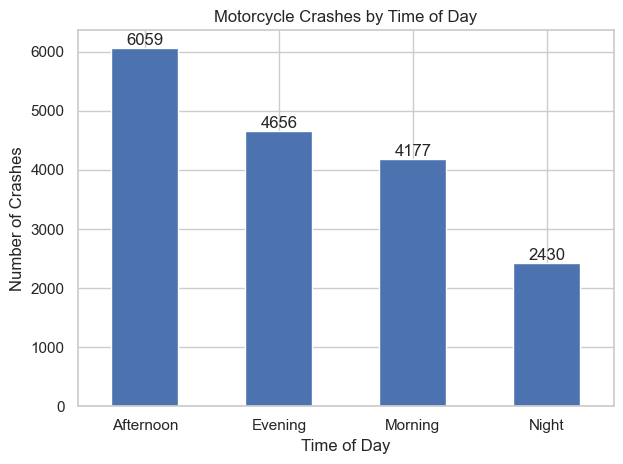

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Create time-of-day bins from COLLISION_TIME (HHMM format)
def time_bin(t):
    if pd.isna(t):
        return None
    t = int(t)
    if 500 <= t < 1200:
        return 'Morning'
    elif 1200 <= t < 1700:
        return 'Afternoon'
    elif 1700 <= t < 2100:
        return 'Evening'
    else:
        return 'Night'

df['TIME_OF_DAY'] = df['COLLISION_TIME'].apply(time_bin)

# Count crashes per time category
time_counts = df['TIME_OF_DAY'].value_counts().sort_index()

# Plot
ax = time_counts.plot(
    kind='bar',
    title='Motorcycle Crashes by Time of Day',
    xlabel='Time of Day',
    ylabel='Number of Crashes'
)

ax.tick_params(axis='x', rotation=0)

# Add value labels
for i, v in enumerate(time_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()


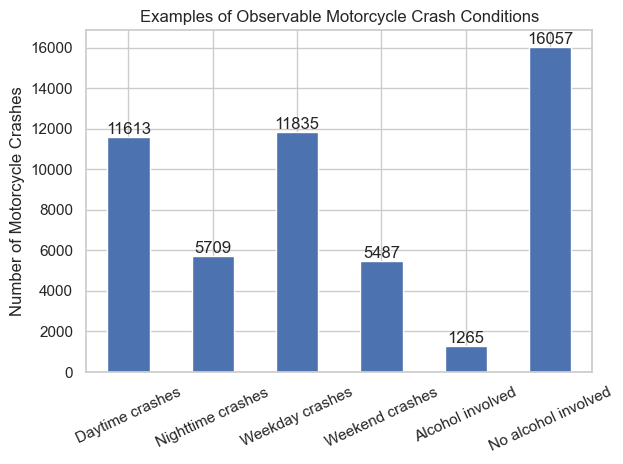

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# --- TIME OF DAY: Day vs Night ---
day_crashes = df['COLLISION_TIME'].apply(
    lambda x: 600 <= int(x) < 1800 if pd.notna(x) else False
).sum()

night_crashes = df['COLLISION_TIME'].apply(
    lambda x: int(x) >= 1800 or int(x) < 600 if pd.notna(x) else False
).sum()

# --- DAY OF WEEK: Weekday vs Weekend ---
weekday_crashes = df['DAY_OF_WEEK'].isin([1, 2, 3, 4, 5]).sum()
weekend_crashes = df['DAY_OF_WEEK'].isin([6, 7]).sum()

# --- ALCOHOL INVOLVEMENT ---
alcohol_yes = df['ALCOHOL_INVOLVED'].eq('Y').sum()
alcohol_no = df['ALCOHOL_INVOLVED'].ne('Y').sum()

# Combine into one series
conditions = pd.Series({
    'Daytime crashes': day_crashes,
    'Nighttime crashes': night_crashes,
    'Weekday crashes': weekday_crashes,
    'Weekend crashes': weekend_crashes,
    'Alcohol involved': alcohol_yes,
    'No alcohol involved': alcohol_no
})

# Plot
ax = conditions.plot(
    kind='bar',
    title='Examples of Observable Motorcycle Crash Conditions',
    ylabel='Number of Motorcycle Crashes'
)

ax.tick_params(axis='x', rotation=25)

# Add labels
for i, v in enumerate(conditions):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()


#### Alcohol involvement

In [ ]:
alcohol_counts = df['ALCOHOL_INVOLVED'].value_counts(dropna=False)

alcohol_counts.plot(
    kind='bar',
    title='Alcohol Involvement in Motorcycle Crashes',
    xlabel='Alcohol Involved',
    ylabel='Number of Crashes'
)

plt.tight_layout()
plt.show()


#### Crashes by day of week

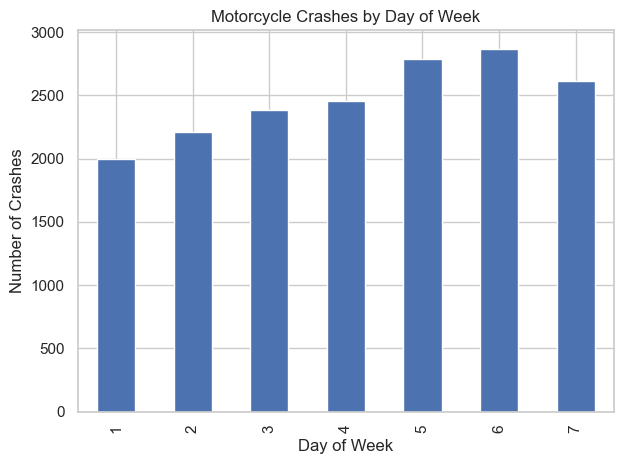

In [25]:
dow_counts = df['DAY_OF_WEEK'].value_counts().sort_index()

dow_counts.plot(
    kind='bar',
    title='Motorcycle Crashes by Day of Week',
    xlabel='Day of Week',
    ylabel='Number of Crashes'
)

plt.tight_layout()
plt.show()


#### Slide #8 Recamp Summary Visual Aid

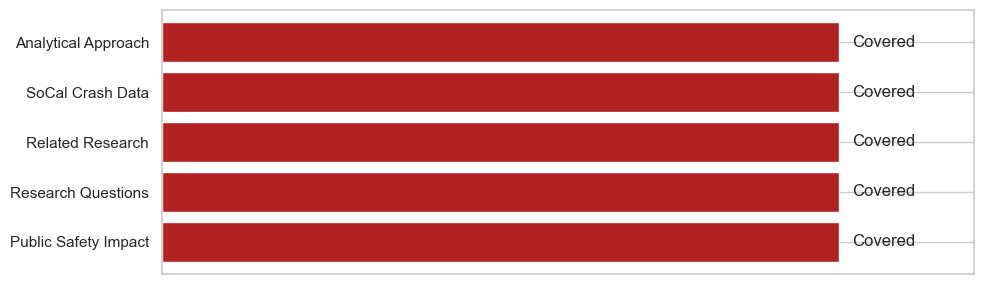

In [58]:
import matplotlib.pyplot as plt

severity_counts = df['COLLISION_SEVERITY'].value_counts().sort_index()

labels = [
    "Fatal",
    "Severe Injury",
    "Other Visible Injury",
    "Complaint of Pain"
]

plt.figure(figsize=(8, 4))

bars = plt.bar(labels, severity_counts)

plt.ylabel("Number of Motorcycle Crashes")
plt.xlabel("Injury Severity")
plt.title("")  # leave blank for slide title

# Add counts on bars
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        int(bar.get_height()),
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()


#### Sorting and Filtering

# Split the Data for Training and Testing

##### Interpretation

# Model | Artificial Neural Network (ANN) | Train | Tune | Evaluation


#### Build the Model

##### Interpretation

#### Train the Model

##### Interpretation

#### Tune the Model

##### Interpretation

#### Evaluate the Model


# Model | Artificial Neural Network (ANN) | Train | Tune | Evaluation

#### Build the Model

##### Interpretation

#### Train the Model

##### Interpretation

#### Tune the Model

##### Interpretation

#### Evaluate the Model


##### Interpretation

# Compare the two models | ANN | CNN

# References  

Scikit-learn Developers. (2024). *Scikit-learn: Machine learning in Python (Version 1.5.0)* [Computer software].  
https://scikit-learn.org/stable/  

Matplotlib Development Team. (2024). *Matplotlib: Visualization with Python* [Computer software].  
https://matplotlib.org/  

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., … Duchesnay, É. (2011). *Scikit-learn: Machine Learning in Python.* *Journal of Machine Learning Research, 12*, 2825–2830.  
https://www.jmlr.org/papers/v12/pedregosa11a.html  

Python Software Foundation. (2024). *Python (Version 3.12)* [Computer software].  
https://www.python.org/  

NumPy Developers. (2024). *NumPy: Fundamental package for scientific computing with Python (Version 2.0)* [Computer software].  
https://numpy.org/  

TensorFlow Developers. (2024). *Keras: Sequential model and convolutional layers.* Retrieved from
https://www.tensorflow.org/guide/keras/sequential_model

TensorFlow Keras Documentation. (2024). *Sequential model and dense layers.* Retrieved from https://www.tensorflow.org/guide/keras/sequential_model

Géron, A. (2022). *Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow* (3rd ed.). O’Reilly Media.

# End Project